In [178]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


The "Diabetes" dataset contains ten baseline variables (such as age, BMI, blood pressure, etc.) for a set of diabetes patients and a target variable (a quantitative measure of disease progression one year after baseline). We will use this dataset to demonstrate the feature importance method for explianing a Logistic Regression model.

We first load the "Diabetes" dataset and binarize the target values using the median as a threshold:

In [181]:
random_state = 42

# Load the Diabetes dataset
diabetes_data = load_diabetes(scaled=False)
X = pd.DataFrame(diabetes_data.data, columns=diabetes_data.feature_names)
y = diabetes_data.target 

# binarizing the target
y = y>=np.median(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

Standardizing features is a best practice when using linear models, as it ensures that each feature contributes equally to the model's predictions and prevents any feature from dominating the others due to its scale.

In [184]:
# Standardizing features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)


# Create and fit the Random Forest Regressor model
model = LogisticRegression()
model.fit(X_train_standardized, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test_standardized)

Evaluating the performance of the classifier is crucial to understand how well it fits the data. We use accuracy to evaluate the generalization performance of the classifier:

In [187]:
# Calculating the accuracy
acc = accuracy_score(y_test, y_pred)

print(f'Classifier Accuracy: {acc}')

Classifier Accuracy: 0.7303370786516854


No we can compute the odds ration for each coefficient $\beta_j$ using the following formula: $odds_j = e^{\beta_j}$

In [190]:
# Retrieve the coefficients and feature names
coefficients = model.coef_
feature_names = diabetes_data.feature_names

# Computing odds ratio
feature_importance = np.exp(coefficients).squeeze()


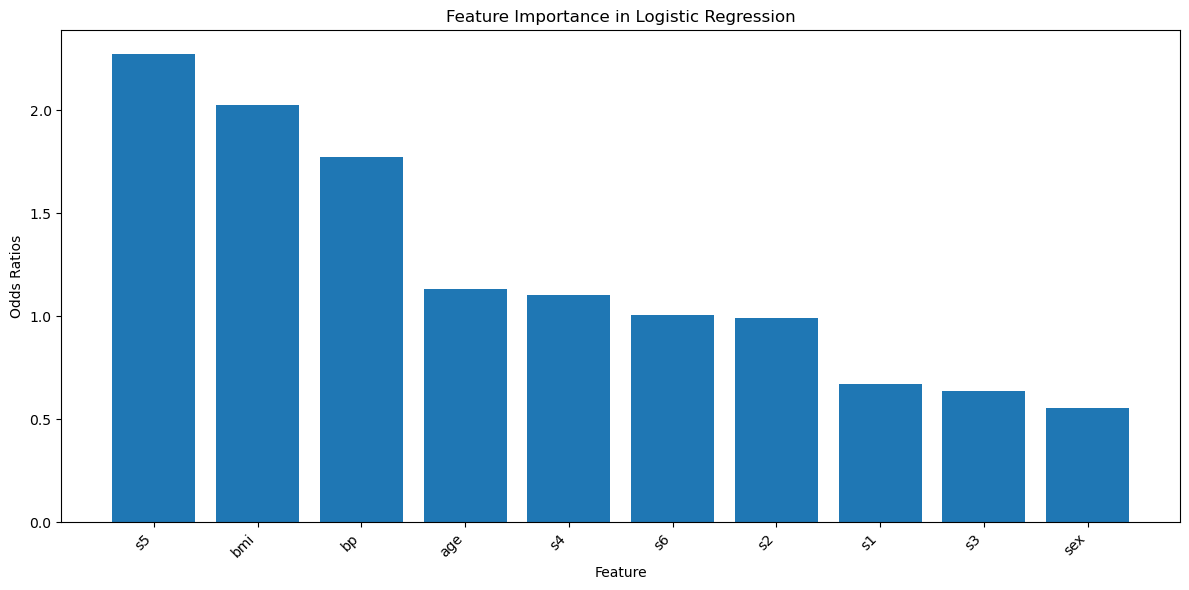

In [192]:


# Create a DataFrame to store the coefficients with their corresponding feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'OR': feature_importance})


# Sort the DataFrame by coefficient magnitude in descending order
coeff_df = coeff_df.reindex(coeff_df['OR'].abs().sort_values(ascending=False).index)

# Create a bar plot to visualize coefficient magnitudes
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)
plt.bar(coeff_df['Feature'], coeff_df['OR'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Odds Ratios')
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()

**Exercise 3:** How can we make our estimation of feature importance in Logistic Regression more robust using the bagging approach? Give it a quick try and discuss your solution on the discussion board (Hint: thinks of measuring the stability of odds in bagged estimates).

In [207]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import r2_score

random_state = 42

# Creating, estimating, and predicting using a bag of 100 Logistic regressor models.
n_estimators = 100

bagged_model = BaggingRegressor(estimator=LogisticRegression(), 
                                n_estimators=n_estimators, 
                                random_state=random_state)
bagged_model.fit(X_train_standardized, y_train)

y_pred = bagged_model.predict(X_test_standardized)

# Calculate R-squared value
r2 = r2_score(y_test, y_pred)


In [209]:
coefficients = []
for i in range(n_estimators):
    coefficients.append(bagged_model.estimators_[i].coef_)
coefficients = np.vstack(coefficients)

#feature_importance = np.mean(coefficients, axis=0) / (np.std(coefficients, axis=0)/n_estimators**0.5)
feature_importance = np.exp(np.mean(coefficients, axis=0)).squeeze()


# Create a DataFrame to store the feature importance with their corresponding feature names
fi_df = pd.DataFrame({'Feature': feature_names, 't_stats': feature_importance})

# Sort the DataFrame of feature importance in descending order
fi_df = fi_df.reindex(fi_df['t_stats'].abs().sort_values(ascending=False).index)

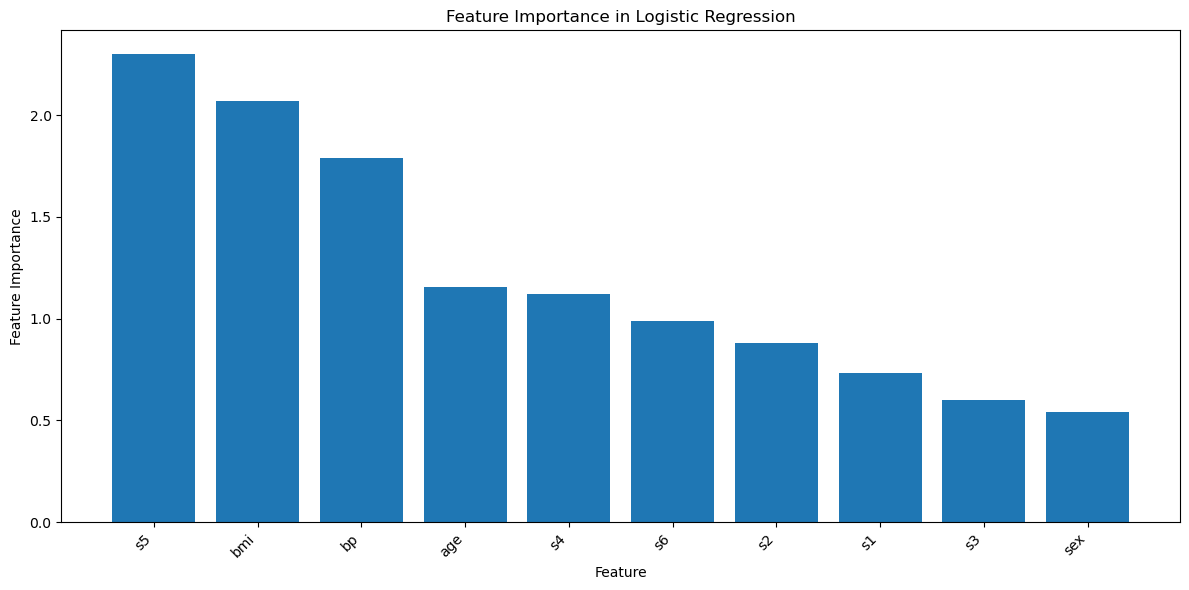

In [211]:
# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(fi_df['Feature'], fi_df['t_stats'])
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Feature Importance')
plt.title('Feature Importance in Logistic Regression')
plt.tight_layout()
plt.show()